# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp

from salishsea_tools import nc_tools, geo_tools

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
def get_data(mydata, section, time):
    lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

In [4]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [5]:
def tranCS(section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]
    
#     vmax = 0.000006
    vmax = 200/sum(transports)
    
#     fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    c, xedge, yedge, im = ax.hist2d(dist, 
                            depths,
                            weights=transports,
                            bins=[np.array(t_dist[lonW:lonE]), t_depths], cmap=cm.matter, vmax = vmax, density=True, zorder=1) 
    
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid],
            mask=1-tmask[:, igrid]) +
            np.ma.array(xr.open_dataset(salfile).vosaline[0, :, igrid+1],
            mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g', zorder = 2)
    
    pc = draw_patches(fmask, lonW, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)
    
    # the histogram will integrate to 1, given density=True, manually set the range of the colourbar so it reflects the actual speeds
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, np.round(((vmax*sum(transports)).values),1)]) #i think you have to divide transport by num days and num hours in day, ask susan why
    cb1.set_label('m s$^{-1}$', labelpad=-20)

    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

In [6]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 200]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]
straits = [admiralty, rosario, sanjuan, haro]
names = ['Admiralty', 'Rosario', 'San Juan', 'Haro']

# March
## Backwards run (source water, going from strait in title to the JDF)

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

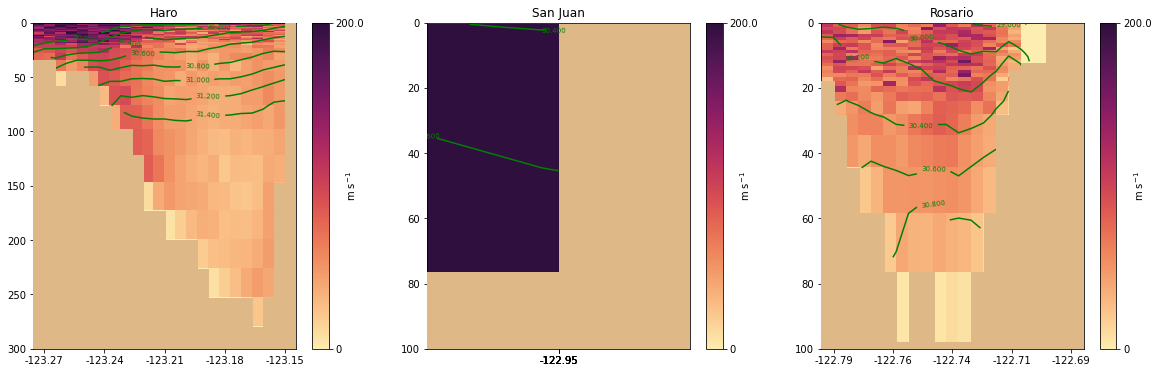

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [9]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01mar19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15mar19/SalishSea_1d_20190315_20190315_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

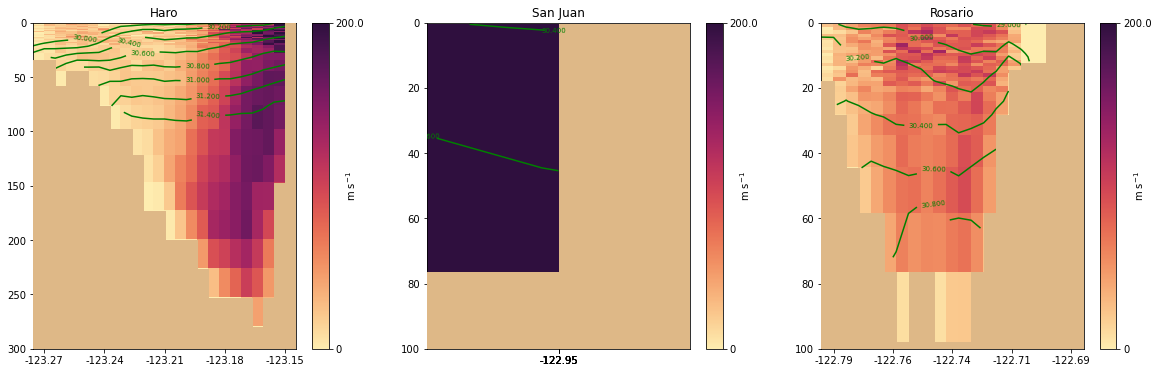

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# June
## Backwards run (source water, going from strait in title to the JDF)

In [11]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01jun19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

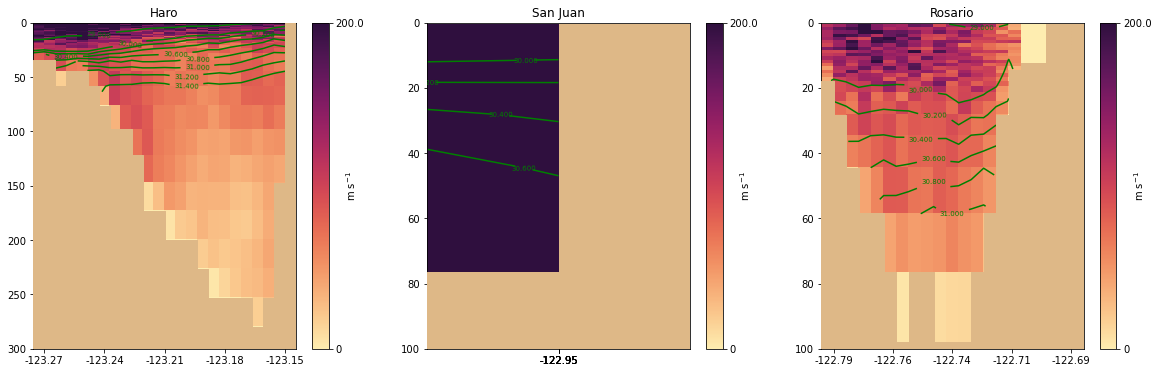

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [13]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01jun19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15jun19/SalishSea_1d_20190615_20190615_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

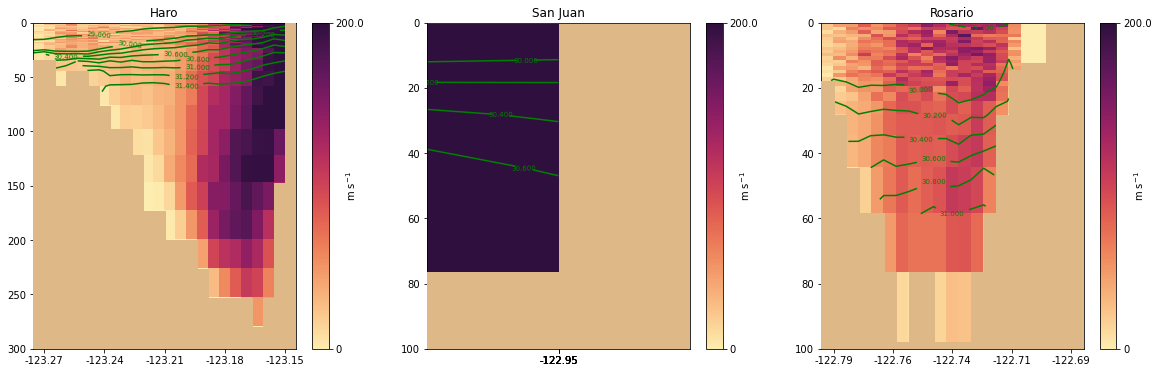

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# September
## Backwards run (source water, going from strait in title to the JDF)

In [15]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01sep19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

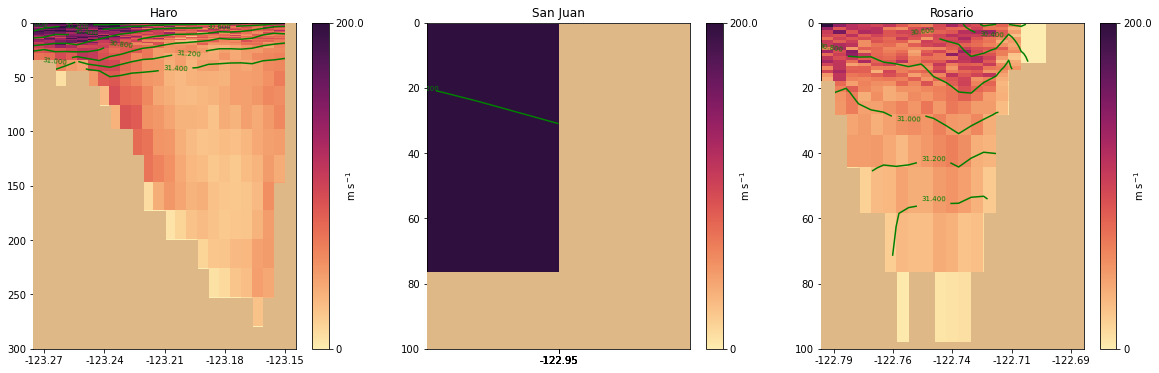

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [17]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01sep19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15sep19/SalishSea_1d_20190915_20190915_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

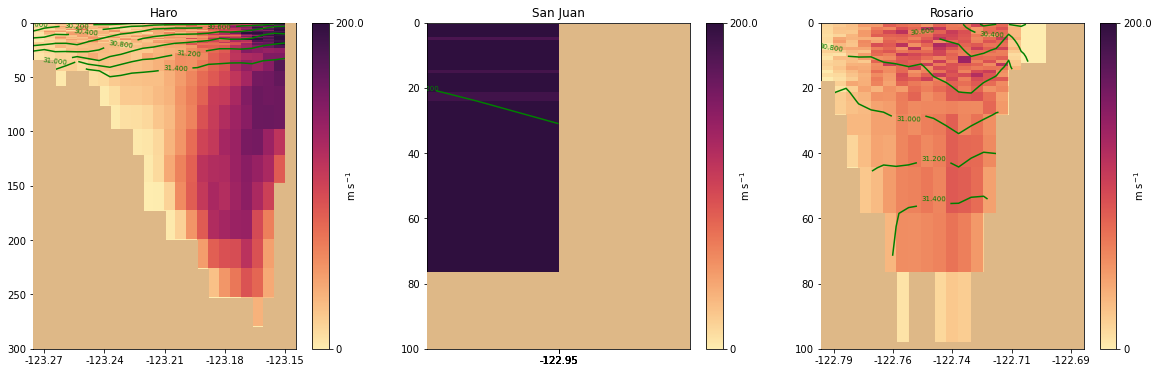

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# December
## Backwards run (source water, going from strait in title to the JDF)

In [19]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward_01dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

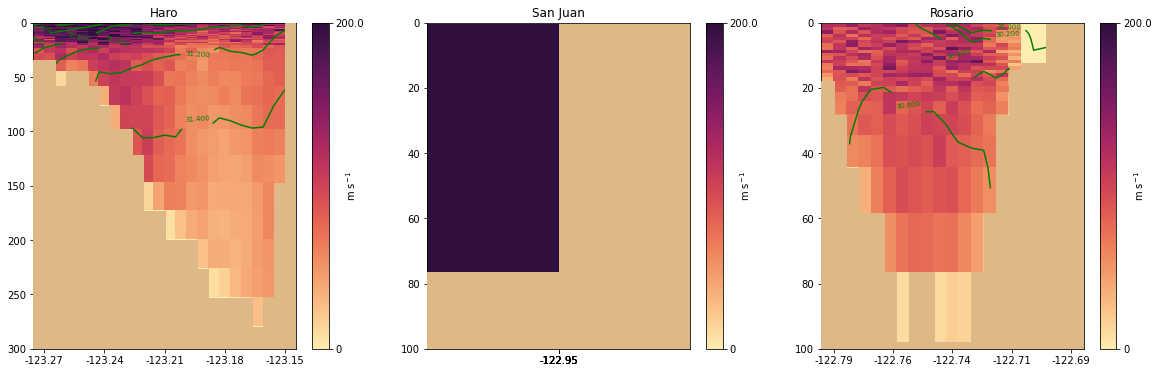

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

## Forwards run (from JDF to these straits)

In [21]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward_01dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

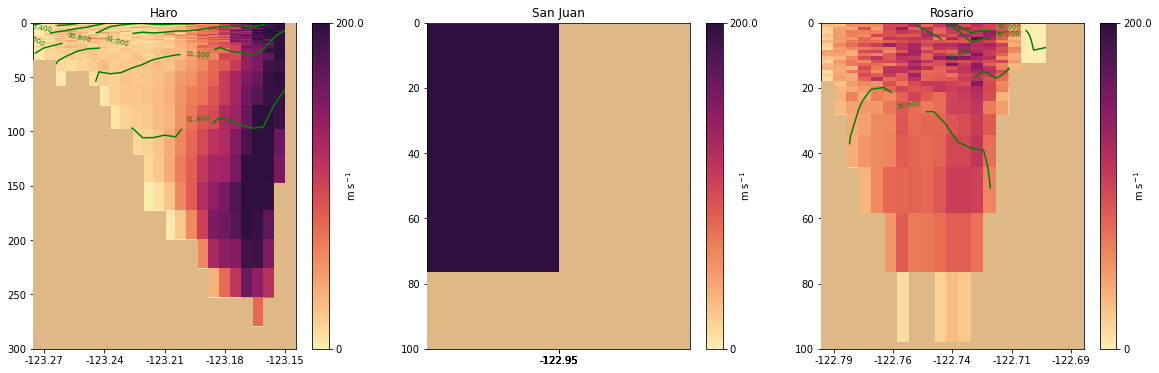

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

# One year 
### Forward

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/forward1yr_01jan19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")

### Backward

In [ ]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/jordan_manydays/backward1yr_31dec19/ariane_positions_quantitative.nc'
salfile = '/results2/SalishSea/nowcast-green.201905/15dec19/SalishSea_1d_20191215_20191215_grid_T.nc'
mydata = xr.open_dataset(file)
time1 = mydata.init_t[0]

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
tranCS(haro[0], haro[1], haro[2], haro[3], haro[4], axs[0], "Haro")
tranCS(sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1], "San Juan")
tranCS(rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2], "Rosario")